Notebook purpose: evaluate how efficiently we could search for catalysts using the ML model under various constraints.

The most conspicuous constraint is to find a set number of active catalysts without any unnecessary DFT calculations
What is unnecessary? --> 100% of O2 binding calculations are to actual binding sites
So we can accept a model with lower accuracy as long as it has no false positives --> only a small penalty for false negatives

Let's say we're only willing to run 5 DFT O2 binding calculations, and we want basically all of them to show that we found active sites. We'd probably want each of these to be per catalyst, to show that we've found 5 unique active catalysts. Assuming we're working with 10% of the data as a "test" set, that's about 27 calalysts, so we want to pick the ones that the model is most confident have at least 1 site that binds O2.

Really, this is a question of whether the active sites for a set of catalysts are most likely to actually be binding
Can order by log-loss and take that as an estimate of uncertainty (is that a fair expectation?)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

plt.rcParams.update({'font.size': 20})

In [2]:
from ngcc_ml import data_tools
from ngcc_ml import skl_tools

In [16]:
def scale_data(train, test, feature_cols, target_col):
        scaler = StandardScaler()
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        X_train_group = scaler.fit_transform(X_train_group)
        X_test_group = scaler.transform(X_test_group)
        y_test_group = test[target_col]
        y_train_group = train[target_col]
        return X_train_group, y_train_group, X_test_group, y_test_group


def group_regression_kfold_evaluate(df, feature_cols, target_col="BindingEnergy", n_splits=10, group_col="Catalyst Name"):
    
    all_mae, all_mse, all_test = [], [], []
    split_groups = GroupKFold(n_splits=n_splits).split(df[feature_cols], df[target_col], df[group_col])
    for train_inds, test_inds in split_groups:
        df_xy = df.copy()
        model_kfg = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group, y_train_group, X_test_group, y_test_group = scale_data(train, test, feature_cols, target_col)
        model_kfg.fit(X_train_group, y_train_group)
        score = model_kfg.score(X_test_group, y_test_group)
        y_test_group_pred = model_kfg.predict(X_test_group)
        test = test.assign(Overpotential_pred=y_test_group_pred)
        mse = mean_squared_error(y_test_group, y_test_group_pred)
        mae = mean_absolute_error(y_test_group, y_test_group_pred)
        all_test.append(test)
        all_mae.append(mae)
        all_mse.append(mse)

        print('MAE of MLP on test set: {:.4f}'.format(mae))
    print("mean:", np.mean(all_mae))
    print("stdev:", np.std(all_mae))
    df_pred_aug = pd.concat(all_test)
    return all_mse, all_mae, df_pred_aug


def group_classification_kfold_evaluate(df, feature_cols, target_col="Doesitbind", n_splits=10, group_col="Catalyst Name"):
    all_scores, all_test = [], []
    split_groups = GroupKFold(n_splits=n_splits).split(df[feature_cols], df[target_col], df[group_col])
    for train_inds, test_inds in split_groups:
        model_kfg = RandomForestClassifier(n_estimators=1000, max_depth=100, class_weight={0:0.5, 1:0.5})
        df_xy = df.copy()
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group, y_train_group, X_test_group, y_test_group = scale_data(train, test, feature_cols, target_col)
        model_kfg.fit(X_train_group, y_train_group)
        score = model_kfg.score(X_test_group, y_test_group)
        y_test_group_pred = model_kfg.predict(X_test_group)
        test = test.assign(Doesitbind_pred=y_test_group_pred)
        all_test.append(test)
        all_scores.append(score)
        print('Accuracy of model on test set: {:.4f}'.format(score))
    df_pred_aug = pd.concat(all_test)
    return all_scores, df_pred_aug

In [5]:
df = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv5.csv", index_col=0)
df["Doesitbind"] = df["Doesitbind"].astype("int")
df_op = pd.read_csv("/home/nricke/work/ngcc_ml/data/intermediate_dGrxn_overpotential.csv", index_col=0)
df_op.rename(columns={"Catalyst": "Catalyst Name"}, inplace=True)
df_op["Atom Number"] = df_op["Active_Site"] + 1
df_op["Catalyst Name"] = "sf" + df_op["Catalyst Name"]
df_op_feat = df_op.merge(df, on=["Atom Number", "Catalyst Name"])

In [24]:
# now get all rows of df that aren't in df_op_feat
df["Catalyst-AtomNum"] = df["Catalyst Name"] + df["Atom Number"].astype(str)
df_op_feat["Catalyst-AtomNum"] = df_op_feat["Catalyst Name"] + df_op_feat["Atom Number"].astype(str)
df_inactive = df[~df["Catalyst-AtomNum"].isin(df_op_feat["Catalyst-AtomNum"].unique())]
df_inactive["Overpotential"] = np.nan

<ipython-input-24-1334322e2b07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inactive["Overpotential"] = np.nan


In [7]:
print(df.shape)
print(df_op_feat.shape)
print(df_inactive.shape)

(4141, 36)
(676, 49)
(3465, 36)


In [8]:
df_op_feat

,Catalyst-AS,O,O2,OH,O2H,Catalyst Name,Energy,dGrxn_O2,dGrxn_O2H,dGrxn_O,...,NeighborChargeDifference,AromaticExtent,RingEdge,NumNitrogens,NumHeteroatoms,ring_nitrogens,atom_plane_deviation,ring_plane_deviation,charge,Catalyst-AtomNum
0,100x0-2,-1280.914436,-1356.003159,-1281.579035,-1356.633806,sf100x0,-1205.807518,-0.744768,-1.742213,-1.358070,...,-0.005618,18,2,1,5,1,6.723311e-02,0.263086,0,sf100x03
1,101x0-11,-1184.855127,-1259.930361,-1185.510968,-1260.562253,sf101x0,-1109.752535,-0.260015,-1.291351,-1.691212,...,-0.001281,26,2,2,2,2,8.277000e-07,0.000003,1,sf101x012
2,101x0-13,-1184.855166,-1259.930279,-1185.510797,-1260.565391,sf101x0,-1109.752535,-0.257795,-1.376726,-1.606908,...,-0.001572,26,2,2,2,2,2.866000e-07,0.000003,1,sf101x014
3,101x0-2,-1184.855173,-1259.930371,-1185.506699,-1260.562253,sf101x0,-1109.752535,-0.260286,-1.291357,-1.692474,...,-0.000591,26,2,2,2,2,9.341000e-07,0.000003,1,sf101x03
4,101x0-24,-1184.855156,-1259.930173,-1185.507057,-1260.562049,sf101x0,-1109.752535,-0.254891,-1.285805,-1.697562,...,-0.000935,26,2,2,2,2,5.660000e-08,0.000003,1,sf101x025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,94x0-8,-725.162751,-800.254837,-725.825515,-800.882777,sf94x0,-650.068231,-0.498935,-1.422713,-1.340210,...,-0.134508,14,2,2,2,1,3.394152e-01,0.047088,0,sf94x09
672,96x0-8,-725.160409,-800.247557,-725.828314,-800.883151,sf96x0,-650.068299,-0.299002,-1.431070,-1.266283,...,-0.133451,14,2,2,2,1,3.485028e-01,0.048038,0,sf96x09
673,97x0-8,-725.160393,-800.247550,-725.828330,-800.883179,sf97x0,-650.068271,-0.299543,-1.432556,-1.265096,...,-0.139417,14,2,2,2,1,3.478376e-01,0.048263,0,sf97x09
674,98x0-8,-725.164526,-800.250403,-725.827466,-800.885084,sf98x0,-650.067016,-0.411349,-1.518571,-1.325708,...,-0.178568,14,2,2,2,1,4.337075e-03,0.011512,0,sf98x09


In [9]:
feature_cols = {"SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "AverageBondLength",  "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"}
not_scaled_cols = {"OrthoOrPara", "Meta", "FartherThanPara", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "RingEdge", "NumNitrogens", "NumHeteroatoms", "ring_nitrogens", "charge"}

In [10]:
gkf_scores, df_gkf_class = group_classification_kfold_evaluate(df, feature_cols)

Accuracy of model on test set: 0.9615
Accuracy of model on test set: 0.9519
Accuracy of model on test set: 0.9423
Accuracy of model on test set: 0.9585
Accuracy of model on test set: 0.9659
Accuracy of model on test set: 0.9537
Accuracy of model on test set: 0.9495
Accuracy of model on test set: 0.9567
Accuracy of model on test set: 0.9399
Accuracy of model on test set: 0.9518


In [17]:
#tc = "dGrxn_O2H"
#tc = "dGrxn_regen"
tc = "Overpotential"
gkf_mse_spec, gkf_mae_spec, df_gkf_spec = group_regression_kfold_evaluate(df_op_feat, feature_cols, target_col=tc)

MAE of MLP on test set: 0.0883
MAE of MLP on test set: 0.0985
MAE of MLP on test set: 0.0700
MAE of MLP on test set: 0.0935
MAE of MLP on test set: 0.1478
MAE of MLP on test set: 0.1072
MAE of MLP on test set: 0.0858
MAE of MLP on test set: 0.0742
MAE of MLP on test set: 0.0624
MAE of MLP on test set: 0.0904
mean: 0.09180782911960818
stdev: 0.022632544467554274


In [120]:
print(len(df["Catalyst Name"].unique()), len(df_gkf_class["Catalyst Name"].unique()))

267 267


In [11]:
print(np.mean(gkf_scores), np.std(gkf_scores))
print(np.mean(gkf_mae_spec), np.std(gkf_mae_spec))

0.9522128523474761 0.007203540989839196
0.07719178112603735 0.014168594846641205


In [74]:
df_gkf_spec.to_csv("df_BindingEnergy_pred.csv")
df_gkf_class.to_csv("df_Doesitbind_pred.csv")

In [42]:
print(df_gkf_class.shape, df_gkf_spec.shape)

(4141, 37) (739, 37)


In [13]:
df[df[["Catalyst Name", "Atom Number"]].duplicated()]

,Unnamed: 0,Atom Number,Catalyst Name,CatalystO2File,Element,SpinDensity,ChElPGPositiveCharge,ChElPGNeutralCharge,ChargeDifference,Doesitbind,...,NeighborChElPGCharge,NeighborChargeDifference,AromaticExtent,RingEdge,NumNitrogens,NumHeteroatoms,ring_nitrogens,atom_plane_deviation,ring_plane_deviation,charge


In [14]:
df_gkf_class[df_gkf_class[["Catalyst Name", "Atom Number"]].duplicated()]

,Unnamed: 0,Atom Number,Catalyst Name,CatalystO2File,Element,SpinDensity,ChElPGPositiveCharge,ChElPGNeutralCharge,ChargeDifference,Doesitbind,...,NeighborChargeDifference,AromaticExtent,RingEdge,NumNitrogens,NumHeteroatoms,ring_nitrogens,atom_plane_deviation,ring_plane_deviation,charge,Doesitbind_pred


In [25]:
# fill df_gkf_class BindingEnergy_pred with values from df_gkf_spec and model predictions on df_inactive
BE_relevant_cols = ["Catalyst Name", "Atom Number", "Overpotential", "Overpotential_pred"]

model = MLPRegressor(max_iter=30000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")

X_train_group = df_op_feat[feature_cols]
X_test_group = df_inactive[feature_cols]
y_train_group = df_op_feat["Overpotential"]

scaler = StandardScaler()
X_train_group = scaler.fit_transform(X_train_group)
X_test_group = scaler.transform(X_test_group)

model.fit(X_train_group, y_train_group)
y_pred = model.predict(X_test_group)

df_inactive = df_inactive.assign(Overpotential_pred=y_pred)
inactive_pred = df_inactive[BE_relevant_cols]
active_pred = df_gkf_spec[BE_relevant_cols]
BE_pred = pd.concat([inactive_pred, active_pred])

In [27]:
df_gkf_merge = df_gkf_class.merge(BE_pred, on=["Catalyst Name", "Atom Number"], suffixes=["","_inactive"])

In [28]:
df_gkf_merge.shape

(4141, 39)

In [35]:
df_gkf_merge["Overpotential_pred"].isna().value_counts()

False    4141
Name: Overpotential_pred, dtype: int64

In [36]:
df_gkf_merge.loc[df_gkf_merge['Doesitbind'] == 0, 'Overpotential'] = 2.0

In [37]:
df_gkf_merge.columns

Index(['Atom Number', 'Catalyst Name', 'CatalystO2File', 'Element',
       'SpinDensity', 'ChElPGPositiveCharge', 'ChElPGNeutralCharge',
       'ChargeDifference', 'Doesitbind', 'BondLength', 'IonizedFreeEnergy',
       'IonizationEnergy', 'BindingEnergy', 'NeutralFreeEnergy', 'OrthoOrPara',
       'Meta', 'FartherThanPara', 'DistanceToN', 'AverageBondLength',
       'BondLengthRange', 'NumberOfHydrogens', 'AromaticSize', 'IsInRingSize6',
       'IsInRingSize5', 'NeighborSpinDensity', 'NeighborChElPGCharge',
       'NeighborChargeDifference', 'AromaticExtent', 'RingEdge',
       'NumNitrogens', 'NumHeteroatoms', 'ring_nitrogens',
       'atom_plane_deviation', 'ring_plane_deviation', 'charge',
       'Catalyst-AtomNum', 'Doesitbind_pred', 'Overpotential',
       'Overpotential_pred'],
      dtype='object')

The situation is a little different now than before, as the model has only made predictions on the sites that are known to be active. To really put together both the classification and regression algorithms, we need to make regression predictions for the inactive sites as well.

1. If we don't train on inactive data, what do the predictions on the inactive sites look like?
2. If we set a fixed value for the inactive data and train on that, does that have a negative effect on the accuracy for predicting on the active sites?

In [46]:
df_ts = df_gkf_merge.copy()
df_ts = df_ts.sort_values(by=["Overpotential"])
df_ts = df_ts.assign(actual_rank=range(df_ts.shape[0]))
df_ts[df_ts["Overpotential"] <= -0.72][["Atom Number", "Catalyst Name", "Doesitbind", "Overpotential", "actual_rank", "BindingEnergy"]]

,Atom Number,Catalyst Name,Doesitbind,Overpotential,actual_rank,BindingEnergy
2265,13,sf19x1,1,-0.818237,0,-0.120009
2101,8,sf139x0,1,-0.811649,1,-0.117149
2495,9,sf122x0,1,-0.804753,2,-0.110626
2848,16,sf82x0,1,-0.791911,3,-0.139696
452,5,sf127x0,1,-0.789254,4,-0.121179
3412,7,sf196x0,1,-0.779399,5,-0.112820
3945,11,sf23x1,1,-0.778850,6,-0.168765
2578,4,sf167x0,1,-0.769447,7,-0.148545
2766,6,sf250x0,1,-0.763502,8,-0.139775
3942,8,sf23x1,1,-0.757450,9,-0.114422


In [44]:
df_ts.shape

(4141, 40)

In [45]:
df_ts_predict_bind = df_ts[df_ts["Doesitbind_pred"] == 1]
print(df_ts_predict_bind.shape)
df_ts_predict_bind = df_ts_predict_bind.sort_values(by="Overpotential_pred")
df_ts_predict_bind = df_ts_predict_bind.assign(pred_rank=range(df_ts_predict_bind.shape[0]))
print(df_ts_predict_bind.shape)

(653, 40)
(653, 41)


In [41]:
df_ts_pred_head = df_ts_predict_bind.sort_values(by=["Overpotential"]).head(19)[["Catalyst Name", "Atom Number", "pred_rank", "actual_rank"]]
df_ts_pred_head = df_ts_pred_head[df_ts_pred_head["actual_rank"] <= 18]

In [42]:
df_ts_pred_head = df_ts_pred_head.sort_values(by="pred_rank")
df_ts_pred_head

,Catalyst Name,Atom Number,pred_rank,actual_rank
1692,sf135x0,8,3,17
2848,sf82x0,16,7,3
2578,sf167x0,4,8,7
1736,sf143x0,3,16,18
2265,sf19x1,13,46,0
2766,sf250x0,6,131,8


In [72]:
ts_rr_all = []
nsims = 1000
for j in range(nsims):
    df_ts_rand = df_ts.assign(random_ordering=np.random.rand(df_ts.shape[0]))
    df_ts_rand = df_ts_rand.sort_values(by="random_ordering")
    df_ts_rand = df_ts_rand.assign(rand_rank=range(df_ts_rand.shape[0]))
    df_ts_rand = df_ts_rand.sort_values(by="actual_rank").head(10)
    df_ts_rand = df_ts_rand.sort_values(by="rand_rank")
    
    ts_rr_pred = []
    for i in range(10):
        rand_count = df_ts_rand.iloc[i]["rand_rank"] + 1
        pred_count = df_ts_pred_head.iloc[i]["pred_rank"] + 1
        ts_rr_pred.append(rand_count/pred_count)

    ts_rr_all.append(ts_rr_pred)

In [73]:
ts_rr_arr = np.array(ts_rr_all)
ts_mean = np.mean(ts_rr_arr, axis=0)
ts_std = np.std(ts_rr_all, axis=0)

print(ts_mean)
print()
print(ts_std)

[368.953      379.615      378.63533333 378.42125    268.29914286
 204.71536364 109.53716667 120.40976    121.20478571  58.02123077]

[345.68861825 230.95596718 173.88180761 144.58571631  84.11217961
  53.26779219  23.83075687  21.01420497  16.11583109   5.30662878]


In [79]:
reg_mean = [251.938,      251.1335,     190.98125,    206.684,      161.026,
 171.19511111, 112.1881875,  108.48,       115.79445,     49.50586538,
  33.26965882,  30.866,       29.90214286,   8.30059447,   1.8115164 ]

reg_std = [2.30487054e+02, 1.62354413e+02, 9.36430074e+01, 8.41326775e+01,
 5.65513855e+01, 5.34623311e+01, 3.07570276e+01, 2.59472072e+01,
 2.49081149e+01, 9.38073379e+00, 5.38916854e+00, 4.33599167e+00, 3.54415625e+00, 7.62934138e-01, 1.12907134e-01]

reg_mean_10 = reg_mean[:10]
reg_std_10 = reg_std[:10]

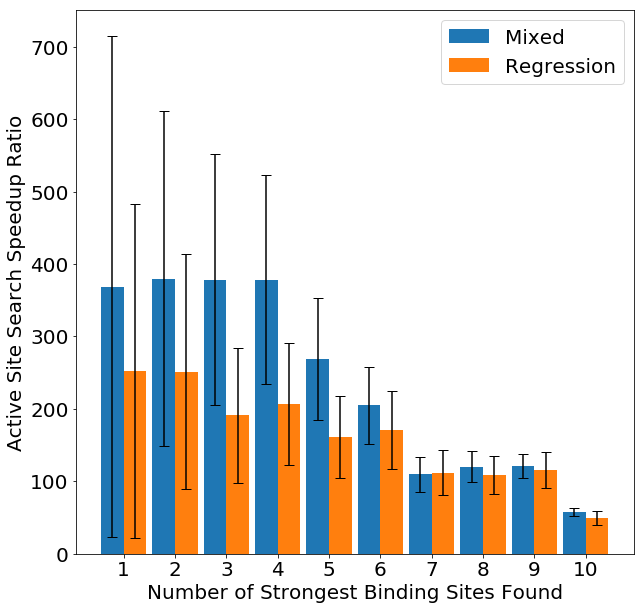

In [92]:
width = 0.44
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.bar(np.arange(10)+1-width/2, ts_mean, width, yerr=ts_std, capsize=5, label="Mixed")
plt.bar(np.arange(10)+1+width/2, reg_mean_10, width, yerr=reg_std_10, capsize=5, label="Regression")
plt.xlabel("Number of Strongest Binding Sites Found")
plt.ylabel(r"Active Site Search Speedup Ratio")
ax.set_xticks(np.arange(10)+1)
plt.legend()
plt.savefig("RegressionSpeedupComparison.png")

In [68]:

print(ts_rr.iloc[4], ts_rr.iloc[9])

1218 2592


In [71]:
ts_rr_pred = []
for i in range(15):
    ts_rr_pred.append((ts_rr.iloc[i]+1)/(ts_pred.iloc[i]+1))

[194.0,
 286.5,
 204.5,
 232.4,
 152.375,
 150.22222222222223,
 146.5625,
 127.10526315789474,
 124.2,
 49.86538461538461,
 34.56470588235294,
 30.76,
 28.151785714285715,
 7.988479262672811,
 1.8809746954076851]

In [ ]:
# for each index in df_ts_best
# 

In [16]:
l_O2, c_O2 = search_for_active_catalysts(df_ts, order_col="random_ordering", feature_cols=feature_cols, find_num=100)
print(len(l_O2), c_O2)
l_t, c_t = search_for_active_catalysts(df_ts, order_col="Doesitbind_predproba", feature_cols=feature_cols, find_num=100)
print(len(l_t), c_t)

100 607
100 101
